In [1]:
import pandas as pd
import backtrader as bt
import matplotlib.pyplot as plt
import datetime as dt
import yfinance as yf
import numpy as np

## Rebalancing strategy on value stocks
We pick several values stocks, and develop a swing strategy, and compare the results with buy and hold strategy.

In [2]:
tickers = ['BMY', 'WMT', 'KO', 'CVS', 'VZ']

In [3]:
stocks = yf.download(tickers, start = "2005-01-01", end = "2015-01-01")

[*********************100%***********************]  5 of 5 completed


In [4]:
stocks.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2517 entries, 2005-01-03 to 2014-12-31
Data columns (total 30 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   (Adj Close, BMY)  2517 non-null   float64
 1   (Adj Close, CVS)  2517 non-null   float64
 2   (Adj Close, KO)   2517 non-null   float64
 3   (Adj Close, VZ)   2517 non-null   float64
 4   (Adj Close, WMT)  2517 non-null   float64
 5   (Close, BMY)      2517 non-null   float64
 6   (Close, CVS)      2517 non-null   float64
 7   (Close, KO)       2517 non-null   float64
 8   (Close, VZ)       2517 non-null   float64
 9   (Close, WMT)      2517 non-null   float64
 10  (High, BMY)       2517 non-null   float64
 11  (High, CVS)       2517 non-null   float64
 12  (High, KO)        2517 non-null   float64
 13  (High, VZ)        2517 non-null   float64
 14  (High, WMT)       2517 non-null   float64
 15  (Low, BMY)        2517 non-null   float64
 16  (Low, CVS)        2517 n

In [5]:
stocks.drop(columns=[column for column in stocks.columns if column[0] == 'Adj Close'], inplace=True)
stocks.head(3)

Close                                                High  \
                  BMY        CVS      KO         VZ        WMT        BMY   
Date                                                                        
2005-01-03  25.430000  22.500000  20.770  36.413578  53.349998  25.670000   
2005-01-04  25.150000  22.245001  20.480  36.044857  53.220001  25.610001   
2005-01-05  24.790001  22.625000  20.385  35.990898  53.290001  25.020000   

                                                        ...   Open             \
                  CVS         KO         VZ        WMT  ...    BMY        CVS   
Date                                                    ...                     
2005-01-03  22.825001  20.985001  36.926193  54.299999  ...  25.57  22.700001   
2005-01-04  22.690001  20.825001  36.656395  53.889999  ...  25.60  22.625000   
2005-01-05  22.645000  20.600000  36.431564  53.639999  ...  25.00  22.245001   

                                          Volume                               \
                   KO         VZ    WMT      BMY      CVS        KO        VZ   
Date                                                                            
2005-01-03  20.950001  36.692368  53.75  4997300  5114400  14072000   9236061   
2005-01-04  20.770000  36.584450  53.77  5681300  4172800  16860200  11680234   
2005-01-05  20.500000  36.080830  53.50  5606300  5192400  13271000   8201616   

                      
                 WMT  
Date                  
2005-01-03  16078400  
2005-01-04  10596700  
2005-01-05   8241500  

[3 rows x 25 columns]

In [6]:
class proportional_balance(bt.Strategy):
    def __init__(self):
        pass
    
    def next(self):      
        today = self.data.datetime.date
        pct = 0.95/len(tickers)
        for stock in tickers:
            self.order_target_percent(target=pct, data=stock)
            
#     def stop(self):
#         print('The final porfolio value is {}'.format(self.broker.getvalue()))


In [7]:
cerebro = bt.Cerebro()
for stock in tickers:
    df = stocks[[column for column in stocks.columns if (column[1] == stock)]]
    df.columns = df.columns.get_level_values(0)
    df = df.div(df['Open'][0])
#     print(df)
    datafeed = bt.feeds.PandasData(dataname=df)
    cerebro.adddata(datafeed, name=stock)
    

In [8]:
cerebro.addstrategy(proportional_balance)

0

In [9]:
cerebro.broker.setcash(100000)

In [10]:
cerebro.addanalyzer(bt.analyzers.SharpeRatio)
cerebro.addanalyzer(bt.analyzers.DrawDown)
cerebro.addanalyzer(bt.analyzers.TimeReturn)
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer)

<IPython.core.display.Javascript object>


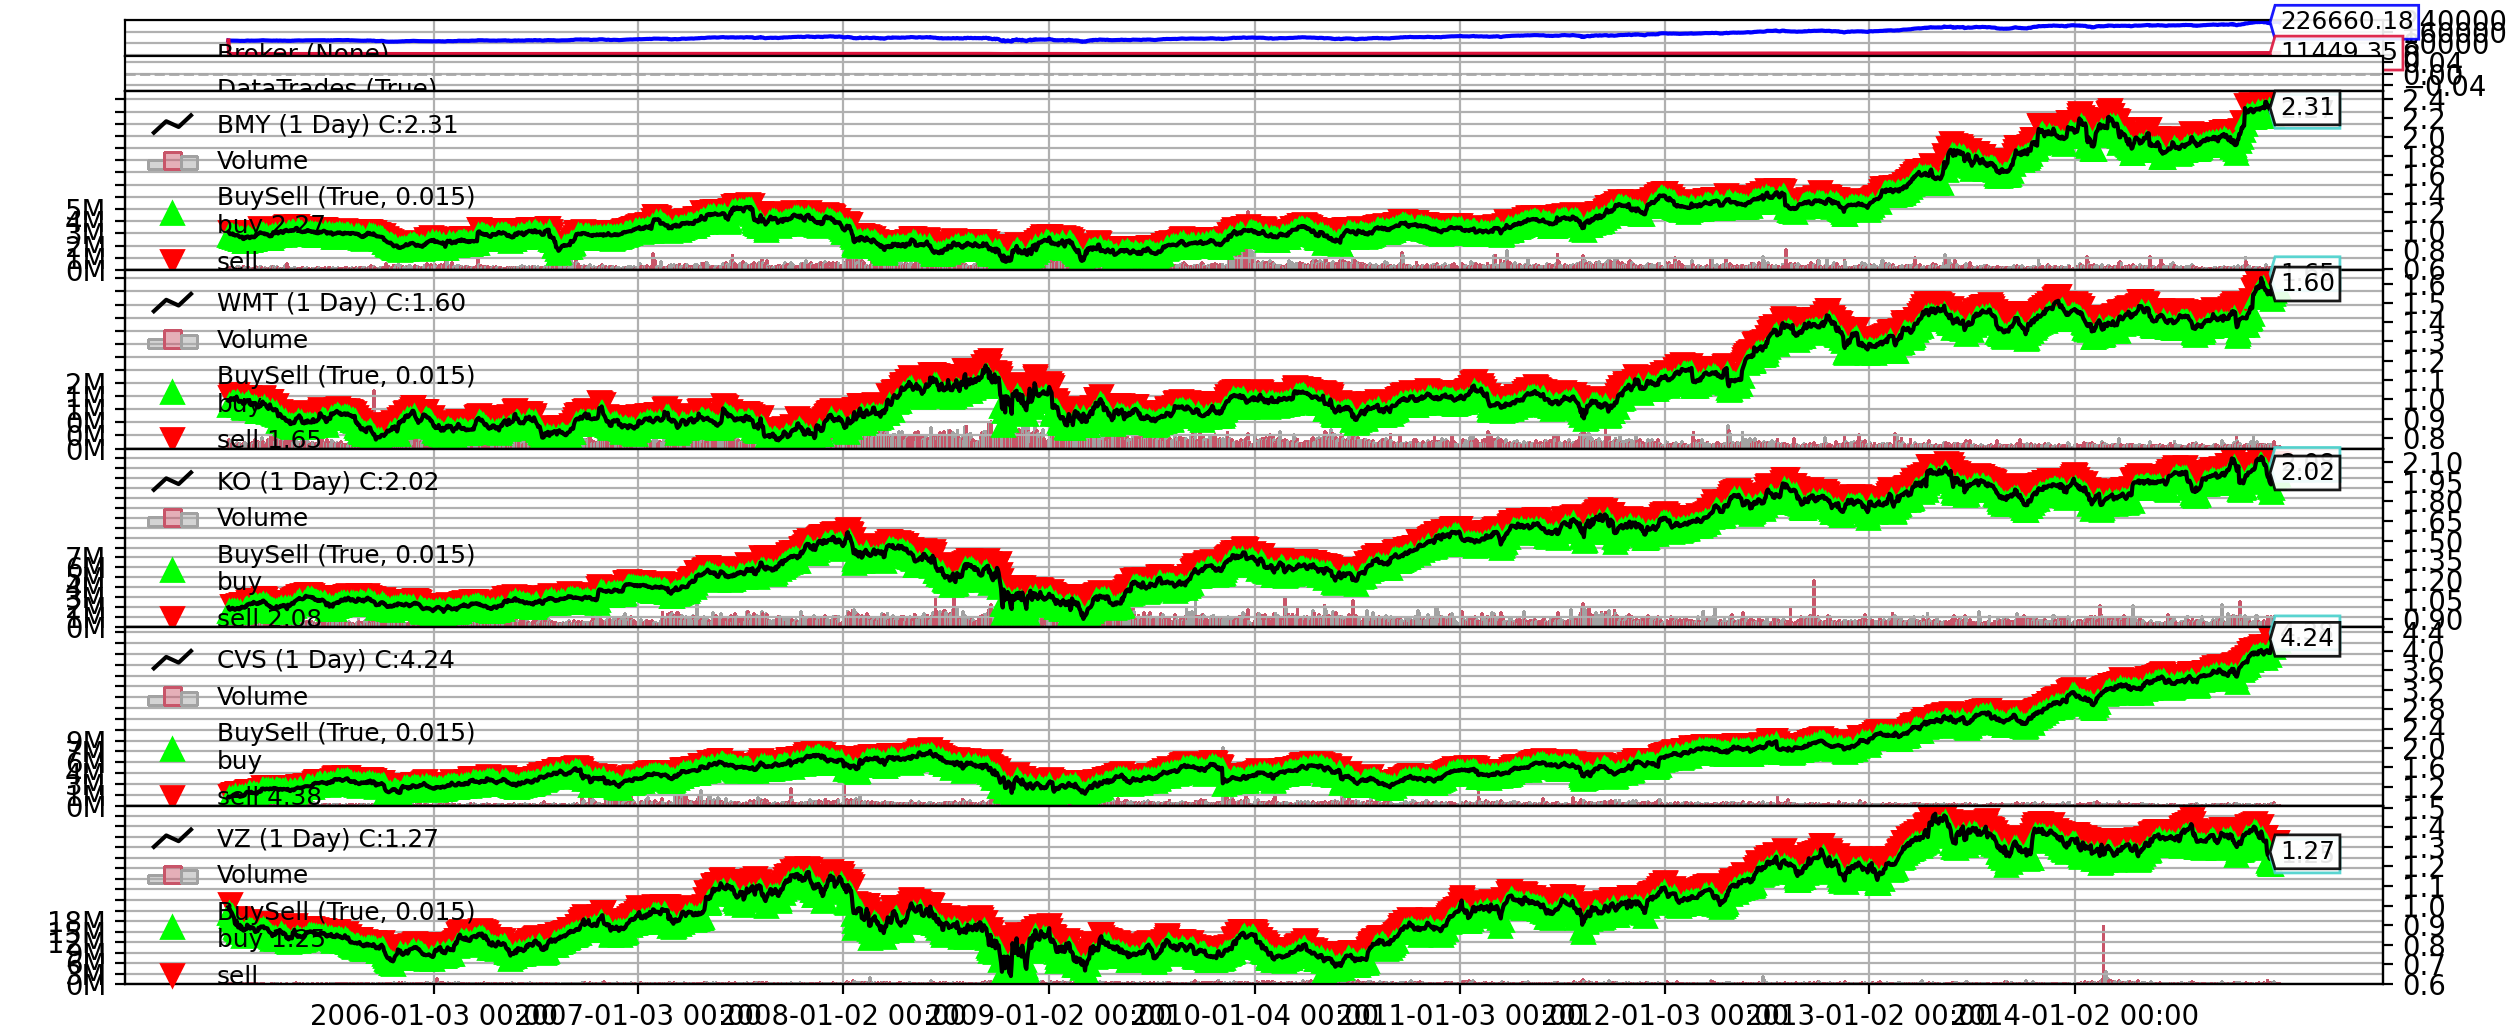

[[<Figure size 432x288 with 12 Axes>]]

In [11]:
res = cerebro.run()[0]
cerebro.plot(width=200, height=200)

##### We compute some metrics, including Sharpe ratio and our final porfolio value (with initial cash = 10^5)

In [17]:
print('the Sharpe ratio of this strategy is {}, and our final porfolio value is {}'.format(res.analyzers.sharperatio.get_analysis()['sharperatio'], res.broker.getvalue()))

the Sharpe ratio of this strategy is 0.7338324665259931, and our final porfolio value is 226660.18159314524


#### Here we have some other metrics.

In [14]:
res.analyzers.drawdown.get_analysis()

AutoOrderedDict([('len', 22),
                 ('drawdown', 1.9099711164267514),
                 ('moneydown', 4413.439419013652),
                 ('max',
                  AutoOrderedDict([('len', 760),
                                   ('drawdown', 29.683296679435724),
                                   ('moneydown', 38246.49241122416)]))])

## Dual Thrust Strategy on Nasdaq index

##### Data preprocess

In [6]:
nasdaq_1m=pd.read_csv('nasdaq_1m.csv')

In [7]:
nasdaq_1m.head(3)

,01/04/2007;17:00:00;1791.75;1791.75;1790.75;1790.75;56
0,01/04/2007;17:01:00;1791;1791;1790.75;1790.75;11
1,01/04/2007;17:03:00;1790.5;1790.5;1789.75;1789...
2,01/04/2007;17:04:00;1790.25;1790.25;1790.25;17...


In [8]:
from datetime import datetime

In [9]:
nasdaq_1m.rename(columns={'01/04/2007;17:00:00;1791.75;1791.75;1790.75;1790.75;56':'column'}, inplace=True)

In [10]:
nasdaq_1m['time']=nasdaq_1m['column'].apply(lambda x: x.split(';')[0]+" "+x.split(';')[1]).apply(lambda x: datetime.strptime(x, '%d/%m/20%y %H:%M:%S'))

In [11]:
nasdaq_1m['open']=nasdaq_1m['column'].apply(lambda x: x.split(';')[2]).astype('float')
nasdaq_1m['high']=nasdaq_1m['column'].apply(lambda x: x.split(';')[3]).astype('float')
nasdaq_1m['low']=nasdaq_1m['column'].apply(lambda x: x.split(';')[4]).astype('float')
nasdaq_1m['close']=nasdaq_1m['column'].apply(lambda x: x.split(';')[5]).astype('float')
nasdaq_1m['volume']=nasdaq_1m['column'].apply(lambda x: x.split(';')[6]).astype('int32')

In [12]:
nasdaq_1m.set_index('time', inplace=True)

In [13]:
nasdaq_1m.drop(columns='column', inplace=True)

In [14]:
nasdaq_1m['open'].head(3)

time
2007-04-01 17:01:00    1791.00
2007-04-01 17:03:00    1790.50
2007-04-01 17:04:00    1790.25
Name: open, dtype: float64

In [15]:
nasdaq_1m_used=nasdaq_1m.loc['2020-01-01':'2020-06-30']
nasdaq_1m_used.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 172493 entries, 2020-01-01 17:00:00 to 2020-06-30 23:59:00
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   open    172493 non-null  float64
 1   high    172493 non-null  float64
 2   low     172493 non-null  float64
 3   close   172493 non-null  float64
 4   volume  172493 non-null  int32  
dtypes: float64(4), int32(1)
memory usage: 7.2 MB


In [16]:
nasdaq_1m.fillna('ffill', inplace=True)

In [17]:
nq_minute_bar=bt.feeds.PandasData(dataname=nasdaq_1m_used,
                            fromdate=datetime(2020,1,1),
                            todate=datetime(2020,5,30),
                            timeframe=bt.TimeFrame.Minutes)

In [23]:
cerebro2=bt.Cerebro()
cerebro2.adddata(nq_minute_bar)
cerebro2.resampledata(nq_minute_bar, timeframe=bt.TimeFrame.Days)
cerebro2.broker.set_cash(100000)

In [24]:
class DT_Line(bt.Indicator):
    lines=('U','D')
    params=(('period',5), ('k_u',0.8), ('k_d',0.5))
    
    def __init__(self):        
        self.addminperiod(self.p.period+1)
        
    def next(self):
        HH=max(self.data.high.get(-1, size=self.p.period))
        LC=min(self.data.close.get(-1, size=self.p.period))
        HC=max(self.data.close.get(-1,size=self.p.period))
        LL=min(self.data.low.get(-1,size=self.p.period))
        R=max(HH-LC,HC-LL)
        
        self.lines.U[0]=self.data.open[0]+self.p.k_u*R
        self.lines.D[0]=self.data.open[0]-self.p.k_d*R

In [25]:
from datetime import time
class dualTrust(bt.Strategy):
    params=(('period',2),('k_u',0.7),('k_d', 0.7))
    
    def __init__(self):
#         self.data1.plotinfo.plot=False
        self.dataclose=self.data0.close
        self.D_Line =DT_Line(self.data1, period=self.p.period, k_u=self.p.k_u, k_d=self.p.k_d)
        self.D_Line=self.D_Line()
        self.D_Line.plotinfo.plotmaster=self.data0
        
        self.buy_signal=bt.indicators.CrossOver(self.dataclose, self.D_Line.U)
        self.sell_signal=bt.indicators.CrossDown(self.dataclose, self.D_Line.D)
        
    def next(self):
        
        if self.data.datetime.time() > time(9,10,0) and self.data.datetime.time() < time(15,30,0):
            if not self.position and self.buy_signal[0]==1:
                self.order=self.buy()
            if not self.position and self.sell_signal[0]==1:
                self.order=self.sell()

            if self.getposition().size<0 and self.buy_signal[0]==1:
                self.order=self.close()
                self.order=self.buy()
            if self.getposition().size>0 and self.sell_signal[0]==1:
                self.order=self.close()
                self.order=self.sell()
        if  self.data.datetime.time() >= time(15, 56, 0) and self.position:
            self.order=self.close()
            
            
    def stop(self):
        print('period: {}, k_u: {}, k_d: {}, final_value: {}'.format(self.p.period, 
                                                                     self.p.k_u, self.p.k_d, self.broker.getvalue()))
            
        

In [26]:
cerebro2.addstrategy(dualTrust)
# cerebro2.optstrategy(dualTrust, period=range(1,5), k_u=[n/10.0 for n in range(2,10)], k_d=[n/10.0 for n in range(2,10)])
cerebro2.run()
# cerebro2.plot(width=200, height=200)

period: 2, k_u: 0.7, k_d: 0.7, final_value: 99224.5


<IPython.core.display.Javascript object>


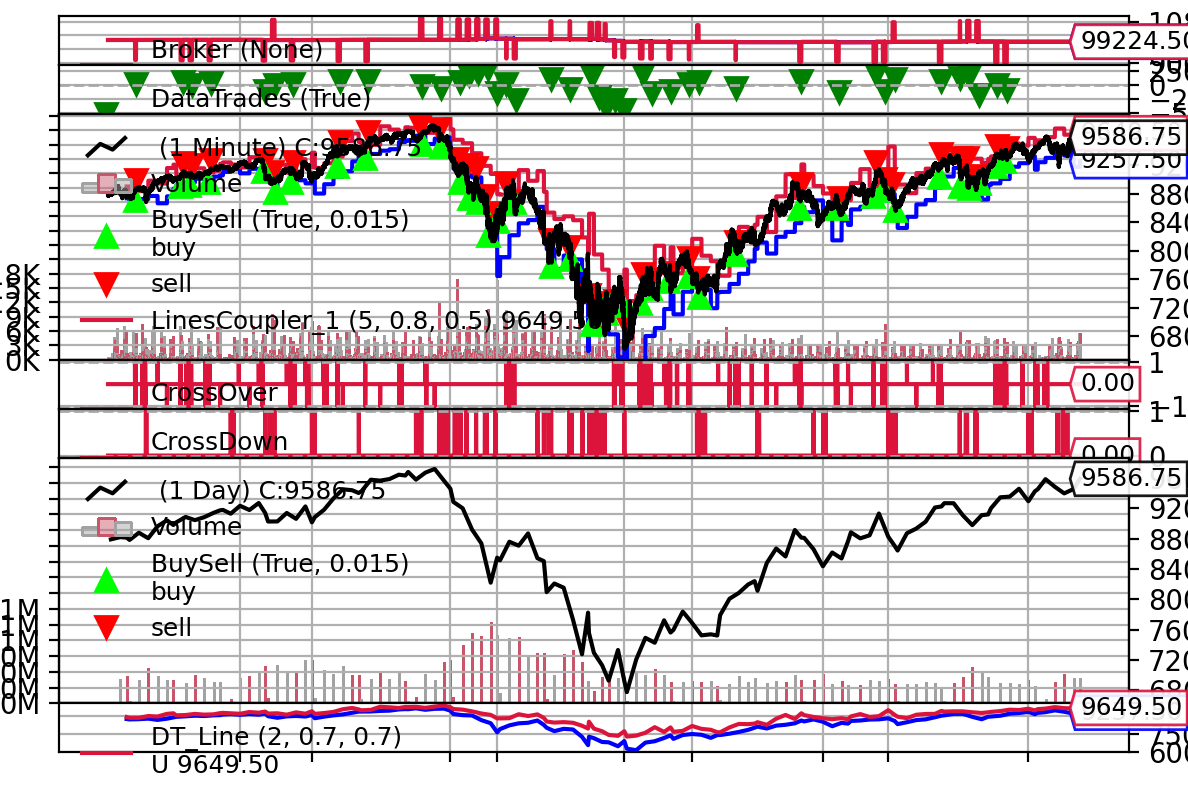

[[<Figure size 432x288 with 9 Axes>]]

In [27]:
cerebro2.plot()